# IMDB
This notebook contains the first few steps of the data science pipeline on a dataset containing movies.

## Group
V2H-Groep 1: Films (IMDB)
- Niels Hoiting
- Jari Oostrom
- Yusuf Syakur

## Research questions
1. What is the correlation between the gender of actors and the popularity of the movie. How does this change overtime?
2. How can we predict a movie's genre with variables like budget, release year, actors, directors, gross, color, and any other variable?
3. To what extend can you predict the gross of a movie based on its popularity on Facebook and IMDB.
4. How accurately can we predict release years from other variables like director, gross, budget, color and any other variable?

bonus. What happens if you cluster keywords from the plot?

## Dataset
movie information with duration, genres, languages, country, budget and gross;
likes on facebook for director, main cast, total cast en the movie itself;
score on IMDB and reviews

## Step 1: Data collection
Import needed libraries. The dataset is already available.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import json

from sklearn.cluster import KMeans

In [2]:
df_movies = pd.read_csv('movie.csv')
df_movies

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,Color,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,NaN,Comedy|Drama,...,6.0,English,Canada,NaN,NaN,2013.0,470.0,7.7,NaN,84
5039,Color,NaN,43.0,43.0,NaN,319.0,Valorie Curry,841.0,NaN,Crime|Drama|Mystery|Thriller,...,359.0,English,USA,TV-14,NaN,NaN,593.0,7.5,16.00,32000
5040,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,...,3.0,English,USA,NaN,1400.0,2013.0,0.0,6.3,NaN,16
5041,Color,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,...,9.0,English,USA,PG-13,NaN,2012.0,719.0,6.3,2.35,660


## Step 2: Data processing (Data munging)
Look at the current dataframe and their types.

In [3]:
df_movies.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


In [4]:
df_movies.dtypes

color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
m

Current column order does not make sense. Order them.

In [5]:
df_movies = df_movies[['movie_imdb_link', 'movie_title', 'imdb_score', 'title_year', 'director_name', 'director_facebook_likes', 'actor_1_name',
                      'actor_1_facebook_likes', 'actor_2_name', 'actor_2_facebook_likes', 'actor_3_name', 'actor_3_facebook_likes',
                      'cast_total_facebook_likes', 'movie_facebook_likes', 'genres', 'budget', 'gross', 'country', 'language',
                      'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users', 'plot_keywords', 'color', 'content_rating',
                      'duration', 'aspect_ratio', 'facenumber_in_poster']]
df_movies

,movie_imdb_link,movie_title,imdb_score,title_year,director_name,director_facebook_likes,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,...,language,num_critic_for_reviews,num_user_for_reviews,num_voted_users,plot_keywords,color,content_rating,duration,aspect_ratio,facenumber_in_poster
0,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,Avatar,7.9,2009.0,James Cameron,0.0,CCH Pounder,1000.0,Joel David Moore,936.0,...,English,723.0,3054.0,886204,avatar|future|marine|native|paraplegic,Color,PG-13,178.0,1.78,0.0
1,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,Pirates of the Caribbean: At World's End,7.1,2007.0,Gore Verbinski,563.0,Johnny Depp,40000.0,Orlando Bloom,5000.0,...,English,302.0,1238.0,471220,goddess|marriage ceremony|marriage proposal|pi...,Color,PG-13,169.0,2.35,0.0
2,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,Spectre,6.8,2015.0,Sam Mendes,0.0,Christoph Waltz,11000.0,Rory Kinnear,393.0,...,English,602.0,994.0,275868,bomb|espionage|sequel|spy|terrorist,Color,PG-13,148.0,2.35,1.0
3,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,The Dark Knight Rises,8.5,2012.0,Christopher Nolan,22000.0,Tom Hardy,27000.0,Christian Bale,23000.0,...,English,813.0,2701.0,1144337,deception|imprisonment|lawlessness|police offi...,Color,PG-13,164.0,2.35,0.0
4,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,Star Wars: Episode VII - The Force Awakens ...,7.1,NaN,Doug Walker,131.0,Doug Walker,131.0,Rob Walker,12.0,...,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,http://www.imdb.com/title/tt3000844/?ref_=fn_t...,Signed Sealed Delivered,7.7,2013.0,Scott Smith,2.0,Eric Mabius,637.0,Daphne Zuniga,470.0,...,English,1.0,6.0,629,fraud|postal worker|prison|theft|trial,Color,NaN,87.0,NaN,2.0
5039,http://www.imdb.com/title/tt2071645/?ref_=fn_t...,The Following,7.5,NaN,NaN,NaN,Natalie Zea,841.0,Valorie Curry,593.0,...,English,43.0,359.0,73839,cult|fbi|hideout|prison escape|serial killer,Color,TV-14,43.0,16.00,1.0
5040,http://www.imdb.com/title/tt2107644/?ref_=fn_t...,A Plague So Pleasant,6.3,2013.0,Benjamin Roberds,0.0,Eva Boehnke,0.0,Maxwell Moody,0.0,...,English,13.0,3.0,38,NaN,Color,NaN,76.0,NaN,0.0
5041,http://www.imdb.com/title/tt2070597/?ref_=fn_t...,Shanghai Calling,6.3,2012.0,Daniel Hsia,0.0,Alan Ruck,946.0,Daniel Henney,719.0,...,English,14.0,9.0,1255,NaN,Color,PG-13,100.0,2.35,5.0


## Step 3: Data Cleaning

Drop overall duplicates first.

In [6]:
print('Before removing duplicates', df_movies.shape)
df_movies = df_movies.drop_duplicates()
print('After removing duplicates:', df_movies.shape)

Before removing duplicates (5043, 28)
After removing duplicates: (4998, 28)


### 3.1 movie_imdb_link

The movie_imdb_link duplicates only differ on a few columns like likes and votes. Extract the unique identifier from the URL and remove these duplicate rows.

In [7]:
pd.concat(gby_result for _, gby_result in df_movies.groupby("movie_imdb_link") if len(gby_result) > 1)

,movie_imdb_link,movie_title,imdb_score,title_year,director_name,director_facebook_likes,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,...,language,num_critic_for_reviews,num_user_for_reviews,num_voted_users,plot_keywords,color,content_rating,duration,aspect_ratio,facenumber_in_poster
3711,http://www.imdb.com/title/tt0046672/?ref_=fn_t...,"20,000 Leagues Under the Sea",7.2,1954.0,Richard Fleischer,130.0,James Mason,617.0,Robert J. Wilke,53.0,...,English,69.0,108.0,22123,captain|expedition|sea|submarine|whale,Color,Approved,127.0,1.37,0.0
4894,http://www.imdb.com/title/tt0046672/?ref_=fn_t...,"20,000 Leagues Under the Sea",7.2,1954.0,Richard Fleischer,130.0,James Mason,618.0,Robert J. Wilke,53.0,...,English,69.0,108.0,22124,captain|expedition|sea|submarine|whale,Color,Approved,127.0,1.37,0.0
890,http://www.imdb.com/title/tt0056193/?ref_=fn_t...,Lolita,7.7,1962.0,Stanley Kubrick,0.0,James Mason,617.0,Shelley Winters,367.0,...,English,103.0,207.0,67822,lolita|nymphet|older man young girl relationsh...,Black and White,Not Rated,152.0,1.66,0.0
4256,http://www.imdb.com/title/tt0056193/?ref_=fn_t...,Lolita,7.7,1962.0,Stanley Kubrick,0.0,James Mason,618.0,Shelley Winters,367.0,...,English,103.0,207.0,67825,lolita|nymphet|older man young girl relationsh...,Black and White,Not Rated,152.0,1.66,0.0
3278,http://www.imdb.com/title/tt0072271/?ref_=fn_t...,The Texas Chain Saw Massacre,7.5,1974.0,Tobe Hooper,365.0,Gunnar Hansen,383.0,Edwin Neal,371.0,...,English,277.0,826.0,96410,cannibal|chainsaw|hitchhiker|independent film|...,Color,R,88.0,1.85,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3317,http://www.imdb.com/title/tt3276924/?ref_=fn_t...,Heist,6.1,2015.0,Scott Mann,8.0,Robert De Niro,22000.0,Joshua Mikel,1000.0,...,English,44.0,57.0,16198,bus|die hard scenario,Color,R,93.0,2.35,1.0
145,http://www.imdb.com/title/tt3332064/?ref_=fn_t...,Pan,5.8,2015.0,Joe Wright,456.0,Hugh Jackman,20000.0,Cara Delevingne,548.0,...,English,256.0,186.0,39956,1940s|child hero|fantasy world|orphan|referenc...,Color,PG,111.0,2.35,4.0
3879,http://www.imdb.com/title/tt3332064/?ref_=fn_t...,Pan,5.8,2015.0,Joe Wright,456.0,Hugh Jackman,20000.0,Cara Delevingne,559.0,...,English,256.0,186.0,39975,1940s|child hero|fantasy world|orphan|referenc...,Color,PG,111.0,2.35,4.0
3158,http://www.imdb.com/title/tt4178092/?ref_=fn_t...,The Gift,7.1,2015.0,Joel Edgerton,0.0,Busy Philipps,1000.0,Allison Tolman,562.0,...,English,297.0,279.0,79909,compulsive liar|fired from a job|gift|rape|sub...,Color,R,108.0,2.35,1.0


In [8]:
df_movies['movie_imdb_link'] = df_movies['movie_imdb_link'].str.extract(r'(?<=title\/)(.*)(?=\/\?)', expand=False)
print('Length before removing duplicates', df_movies.shape)
df_movies = df_movies.drop_duplicates(subset='movie_imdb_link')
print('Length after removing duplicates:',df_movies.shape)

Length before removing duplicates (4998, 28)
Length after removing duplicates: (4919, 28)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### 3.2 movie_title

Strip whitespaces from both ends for the title. Duplicate movie_title rows might be a remake or a reboot of the movie. Leave them.

In [9]:
df_movies['movie_title'] = df_movies['movie_title'].str.strip()

### 3.3 title_year
Rows that have NaN for title_year are series/reviews, not movies. We won't need these for our analysis. CHange title_year to DateTime64 for time series analysis.

In [10]:
df_movies.loc[df_movies['title_year'].isnull()]

,movie_imdb_link,movie_title,imdb_score,title_year,director_name,director_facebook_likes,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,...,language,num_critic_for_reviews,num_user_for_reviews,num_voted_users,plot_keywords,color,content_rating,duration,aspect_ratio,facenumber_in_poster
4,tt5289954,Star Wars: Episode VII - The Force Awakens,7.1,NaN,Doug Walker,131.0,Doug Walker,131.0,Rob Walker,12.0,...,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,0.0
177,tt0086759,Miami Vice,7.5,NaN,NaN,NaN,Don Johnson,982.0,Philip Michael Thomas,321.0,...,English,21.0,74.0,16769,cult tv|detective|drugs|police|undercover,Color,TV-14,60.0,1.33,2.0
260,tt0084967,The A-Team,7.6,NaN,NaN,NaN,George Peppard,669.0,Dirk Benedict,554.0,...,English,29.0,97.0,25402,1980s|cult tv|famous opening theme|good versus...,Color,TV-PG,60.0,4.00,4.0
279,tt1869849,"10,000 B.C.",7.2,NaN,Christopher Barnard,0.0,Mathew Buck,5.0,NaN,NaN,...,NaN,NaN,NaN,6,NaN,NaN,NaN,22.0,NaN,0.0
404,tt2243973,Hannibal,8.6,NaN,NaN,NaN,Caroline Dhavernas,544.0,Scott Thompson,183.0,...,English,103.0,270.0,159910,blood|cannibalism|fbi|manipulation|psychiatrist,Color,TV-14,44.0,1.78,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,tt0813715,Heroes,7.7,NaN,NaN,NaN,Sendhil Ramamurthy,1000.0,Masi Oka,923.0,...,English,75.0,379.0,202115,father daughter relationship|serial killer|sup...,Color,TV-14,60.0,16.00,4.0
4803,tt0197159,Home Movies,8.2,NaN,NaN,NaN,Brendon Small,59.0,Ron Lynch,11.0,...,English,11.0,82.0,7458,coach|friend|school|series|tv series,Color,TV-PG,22.0,1.33,0.0
4819,tt2070791,Revolution,6.7,NaN,NaN,NaN,Billy Burke,2000.0,Tracy Spiridakos,821.0,...,English,23.0,323.0,72017,2020s|near future|one word series title|post a...,Color,TV-14,43.0,16.00,6.0
4869,tt3428912,Happy Valley,8.5,NaN,NaN,NaN,Shirley Henderson,887.0,James Norton,340.0,...,English,11.0,59.0,12848,caravan|police|police sergeant|tied to a chair...,Color,TV-MA,58.0,16.00,1.0


In [11]:
print('Length before removing NaN for title_year:', df_movies.shape)
df_movies = df_movies.drop(df_movies.loc[df_movies['title_year'].isnull()].index)
print('Length after removing NaN for title_year:', df_movies.shape)
df_movies['title_year'] = pd.to_datetime(df_movies['title_year'], format='%Y', errors='coerce')
df_movies

Length before removing NaN for title_year: (4919, 28)
Length after removing NaN for title_year: (4813, 28)


,movie_imdb_link,movie_title,imdb_score,title_year,director_name,director_facebook_likes,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,...,language,num_critic_for_reviews,num_user_for_reviews,num_voted_users,plot_keywords,color,content_rating,duration,aspect_ratio,facenumber_in_poster
0,tt0499549,Avatar,7.9,2009-01-01,James Cameron,0.0,CCH Pounder,1000.0,Joel David Moore,936.0,...,English,723.0,3054.0,886204,avatar|future|marine|native|paraplegic,Color,PG-13,178.0,1.78,0.0
1,tt0449088,Pirates of the Caribbean: At World's End,7.1,2007-01-01,Gore Verbinski,563.0,Johnny Depp,40000.0,Orlando Bloom,5000.0,...,English,302.0,1238.0,471220,goddess|marriage ceremony|marriage proposal|pi...,Color,PG-13,169.0,2.35,0.0
2,tt2379713,Spectre,6.8,2015-01-01,Sam Mendes,0.0,Christoph Waltz,11000.0,Rory Kinnear,393.0,...,English,602.0,994.0,275868,bomb|espionage|sequel|spy|terrorist,Color,PG-13,148.0,2.35,1.0
3,tt1345836,The Dark Knight Rises,8.5,2012-01-01,Christopher Nolan,22000.0,Tom Hardy,27000.0,Christian Bale,23000.0,...,English,813.0,2701.0,1144337,deception|imprisonment|lawlessness|police offi...,Color,PG-13,164.0,2.35,0.0
5,tt0401729,John Carter,6.6,2012-01-01,Andrew Stanton,475.0,Daryl Sabara,640.0,Samantha Morton,632.0,...,English,462.0,738.0,212204,alien|american civil war|male nipple|mars|prin...,Color,PG-13,132.0,2.35,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5037,tt1880418,Newlyweds,6.4,2011-01-01,Edward Burns,0.0,Kerry Bishé,296.0,Caitlin FitzGerald,205.0,...,English,14.0,14.0,1338,written and directed by cast member,Color,Not Rated,95.0,NaN,1.0
5038,tt3000844,Signed Sealed Delivered,7.7,2013-01-01,Scott Smith,2.0,Eric Mabius,637.0,Daphne Zuniga,470.0,...,English,1.0,6.0,629,fraud|postal worker|prison|theft|trial,Color,NaN,87.0,NaN,2.0
5040,tt2107644,A Plague So Pleasant,6.3,2013-01-01,Benjamin Roberds,0.0,Eva Boehnke,0.0,Maxwell Moody,0.0,...,English,13.0,3.0,38,NaN,Color,NaN,76.0,NaN,0.0
5041,tt2070597,Shanghai Calling,6.3,2012-01-01,Daniel Hsia,0.0,Alan Ruck,946.0,Daniel Henney,719.0,...,English,14.0,9.0,1255,NaN,Color,PG-13,100.0,2.35,5.0


### 3.4 actor_1_name
Rows that have NaN for actor_1_name are documentaries, not movies. Remove them.

In [12]:
df_movies.loc[df_movies['actor_1_name'].isnull()]


,movie_imdb_link,movie_title,imdb_score,title_year,director_name,director_facebook_likes,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,...,language,num_critic_for_reviews,num_user_for_reviews,num_voted_users,plot_keywords,color,content_rating,duration,aspect_ratio,facenumber_in_poster
4502,tt2035599,"Pink Ribbons, Inc.",7.4,2011-01-01,Léa Pool,4.0,NaN,NaN,NaN,NaN,...,English,23.0,10.0,591,breast cancer|comma in title|period in title|p...,Color,Not Rated,97.0,NaN,0.0
4519,tt0304692,Sex with Strangers,4.7,2002-01-01,Harry Gantz,0.0,NaN,NaN,NaN,NaN,...,English,12.0,8.0,285,bisexual|explicit sex|sex|stranger|swing,Color,NaN,105.0,1.33,0.0
4720,tt1981703,The Harvest/La Cosecha,7.2,2011-01-01,U. Roberto Romano,6.0,NaN,NaN,NaN,NaN,...,English,3.0,2.0,57,child labor|education|hispanic|labor|migration,Color,NaN,80.0,NaN,0.0
4837,tt0221809,Ayurveda: Art of Being,7.6,2001-01-01,Pan Nalin,95.0,NaN,NaN,NaN,NaN,...,English,15.0,12.0,341,eastern philosophy|healing|india|life,Color,NaN,102.0,1.85,0.0
4945,tt2638024,The Brain That Sings,8.2,2013-01-01,Amal Al-Agroobi,58.0,NaN,NaN,NaN,NaN,...,Arabic,NaN,NaN,18,autism|middle east|music therapy|united arab e...,Color,NaN,62.0,NaN,1.0
4946,tt0488873,The Blood of My Brother,6.6,2005-01-01,Andrew Berends,0.0,NaN,NaN,NaN,NaN,...,English,12.0,7.0,102,american|blood|dream|patrol|tank,Color,NaN,90.0,1.66,1.0
4990,tt4462082,Counting,6.0,2015-01-01,Jem Cohen,6.0,NaN,NaN,NaN,NaN,...,English,12.0,1.0,61,city|city symphony|diary|essay|surveillance,Color,NaN,111.0,1.78,0.0


In [13]:
print('Length before removing NaN for actor_1_name:', df_movies.shape)
df_movies = df_movies.drop(df_movies.loc[df_movies['actor_1_name'].isnull()].index)
print('Length after removing NaN for actor_1_name:', df_movies.shape)
df_movies

Length before removing NaN for actor_1_name: (4813, 28)
Length after removing NaN for actor_1_name: (4806, 28)


,movie_imdb_link,movie_title,imdb_score,title_year,director_name,director_facebook_likes,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,...,language,num_critic_for_reviews,num_user_for_reviews,num_voted_users,plot_keywords,color,content_rating,duration,aspect_ratio,facenumber_in_poster
0,tt0499549,Avatar,7.9,2009-01-01,James Cameron,0.0,CCH Pounder,1000.0,Joel David Moore,936.0,...,English,723.0,3054.0,886204,avatar|future|marine|native|paraplegic,Color,PG-13,178.0,1.78,0.0
1,tt0449088,Pirates of the Caribbean: At World's End,7.1,2007-01-01,Gore Verbinski,563.0,Johnny Depp,40000.0,Orlando Bloom,5000.0,...,English,302.0,1238.0,471220,goddess|marriage ceremony|marriage proposal|pi...,Color,PG-13,169.0,2.35,0.0
2,tt2379713,Spectre,6.8,2015-01-01,Sam Mendes,0.0,Christoph Waltz,11000.0,Rory Kinnear,393.0,...,English,602.0,994.0,275868,bomb|espionage|sequel|spy|terrorist,Color,PG-13,148.0,2.35,1.0
3,tt1345836,The Dark Knight Rises,8.5,2012-01-01,Christopher Nolan,22000.0,Tom Hardy,27000.0,Christian Bale,23000.0,...,English,813.0,2701.0,1144337,deception|imprisonment|lawlessness|police offi...,Color,PG-13,164.0,2.35,0.0
5,tt0401729,John Carter,6.6,2012-01-01,Andrew Stanton,475.0,Daryl Sabara,640.0,Samantha Morton,632.0,...,English,462.0,738.0,212204,alien|american civil war|male nipple|mars|prin...,Color,PG-13,132.0,2.35,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5037,tt1880418,Newlyweds,6.4,2011-01-01,Edward Burns,0.0,Kerry Bishé,296.0,Caitlin FitzGerald,205.0,...,English,14.0,14.0,1338,written and directed by cast member,Color,Not Rated,95.0,NaN,1.0
5038,tt3000844,Signed Sealed Delivered,7.7,2013-01-01,Scott Smith,2.0,Eric Mabius,637.0,Daphne Zuniga,470.0,...,English,1.0,6.0,629,fraud|postal worker|prison|theft|trial,Color,NaN,87.0,NaN,2.0
5040,tt2107644,A Plague So Pleasant,6.3,2013-01-01,Benjamin Roberds,0.0,Eva Boehnke,0.0,Maxwell Moody,0.0,...,English,13.0,3.0,38,NaN,Color,NaN,76.0,NaN,0.0
5041,tt2070597,Shanghai Calling,6.3,2012-01-01,Daniel Hsia,0.0,Alan Ruck,946.0,Daniel Henney,719.0,...,English,14.0,9.0,1255,NaN,Color,PG-13,100.0,2.35,5.0


### 3.5 genres

Genres are split with an '|' delimeter. In total there are 28 unique genres. There are no NaN values. Split them and give them an own boolean column.

In [14]:
list_genres = list(set(itertools.chain.from_iterable(df_movies.genres.str.split('|'))))
print(list_genres)

def add_genre(df, genre):
    genreConcat = 'genre_' + genre
    df_copy = df.copy()
    df_copy[genreConcat] = df_copy['genres'].str.contains(pat = genre)
    return df_copy

for genre in list_genres:
    df_movies = add_genre(df_movies, genre)

df_movies

['Fantasy', 'Adventure', 'Family', 'Biography', 'Romance', 'Crime', 'Mystery', 'Action', 'Thriller', 'News', 'Comedy', 'Drama', 'Animation', 'Documentary', 'Short', 'Sci-Fi', 'Musical', 'Sport', 'History', 'Horror', 'Music', 'Film-Noir', 'War', 'Western']


,movie_imdb_link,movie_title,imdb_score,title_year,director_name,director_facebook_likes,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,...,genre_Short,genre_Sci-Fi,genre_Musical,genre_Sport,genre_History,genre_Horror,genre_Music,genre_Film-Noir,genre_War,genre_Western
0,tt0499549,Avatar,7.9,2009-01-01,James Cameron,0.0,CCH Pounder,1000.0,Joel David Moore,936.0,...,False,True,False,False,False,False,False,False,False,False
1,tt0449088,Pirates of the Caribbean: At World's End,7.1,2007-01-01,Gore Verbinski,563.0,Johnny Depp,40000.0,Orlando Bloom,5000.0,...,False,False,False,False,False,False,False,False,False,False
2,tt2379713,Spectre,6.8,2015-01-01,Sam Mendes,0.0,Christoph Waltz,11000.0,Rory Kinnear,393.0,...,False,False,False,False,False,False,False,False,False,False
3,tt1345836,The Dark Knight Rises,8.5,2012-01-01,Christopher Nolan,22000.0,Tom Hardy,27000.0,Christian Bale,23000.0,...,False,False,False,False,False,False,False,False,False,False
5,tt0401729,John Carter,6.6,2012-01-01,Andrew Stanton,475.0,Daryl Sabara,640.0,Samantha Morton,632.0,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5037,tt1880418,Newlyweds,6.4,2011-01-01,Edward Burns,0.0,Kerry Bishé,296.0,Caitlin FitzGerald,205.0,...,False,False,False,False,False,False,False,False,False,False
5038,tt3000844,Signed Sealed Delivered,7.7,2013-01-01,Scott Smith,2.0,Eric Mabius,637.0,Daphne Zuniga,470.0,...,False,False,False,False,False,False,False,False,False,False
5040,tt2107644,A Plague So Pleasant,6.3,2013-01-01,Benjamin Roberds,0.0,Eva Boehnke,0.0,Maxwell Moody,0.0,...,False,False,False,False,False,True,False,False,False,False
5041,tt2070597,Shanghai Calling,6.3,2012-01-01,Daniel Hsia,0.0,Alan Ruck,946.0,Daniel Henney,719.0,...,False,False,False,False,False,False,False,False,False,False


### 3.6 plot_keywords
Remove '|' delimeter to able to use text mining (if needed).

In [15]:
df_movies['plot_keywords'] = df_movies['plot_keywords'].str.replace('|', ' ')
df_movies['plot_keywords']

0                  avatar future marine native paraplegic
1       goddess marriage ceremony marriage proposal pi...
2                     bomb espionage sequel spy terrorist
3       deception imprisonment lawlessness police offi...
5       alien american civil war male nipple mars prin...
                              ...                        
5037                  written and directed by cast member
5038               fraud postal worker prison theft trial
5040                                                  NaN
5041                                                  NaN
5042    actress name in title crush date four word tit...
Name: plot_keywords, Length: 4806, dtype: object

### 3.7 content_rating
Replace NaN and 'Unrated' with 'Not Rated'.

In [16]:
print(df_movies['content_rating'].unique())

df_movies['content_rating'] = df_movies['content_rating'].str.replace('Unrated', 'Not Rated')
df_movies['content_rating'] = df_movies['content_rating'].fillna(value='Not Rated')

print(df_movies['content_rating'].unique())

['PG-13' 'PG' 'G' 'R' nan 'TV-14' 'Not Rated' 'Unrated' 'Approved' 'NC-17'
 'X' 'GP' 'Passed' 'M' 'TV-G' 'TV-PG']
['PG-13' 'PG' 'G' 'R' 'Not Rated' 'TV-14' 'Approved' 'NC-17' 'X' 'GP'
 'Passed' 'M' 'TV-G' 'TV-PG']


### 3.8 color
All rows with NaN on color are released after 1990. Assume color is used (available since 1950s).

In [17]:
df_movies['color'] = df_movies['color'].fillna(value='Color')
df_movies['color'].unique()

array(['Color', ' Black and White'], dtype=object)

### 3.9 Remove unimportant NaN's

Remove rows that have columns with NaN values. These NaN values can't be filled in by a 'default' value. Leave budget and gross (might turn out to be too much data loss).

In [18]:
print('Length before removing NaNs', len(df_movies))

cols_to_ignore = ['movie_imdb_link', 'budget', 'gross']
df_budget_gross = df_movies[cols_to_ignore]
df_movies = df_movies.drop(['budget', 'gross'], axis=1)

df_movies = df_movies.dropna()

print('Length after removing NaNs', len(df_movies))

df_movies = df_movies.join(df_budget_gross.set_index('movie_imdb_link'), on='movie_imdb_link')

Length before removing NaNs 4806
Length after removing NaNs 4411


### 3.10 Change to int64

In [19]:
df_movies = df_movies.astype({'director_facebook_likes': 'int64',
                            'actor_1_facebook_likes': 'int64',
                            'actor_2_facebook_likes': 'int64',
                            'actor_3_facebook_likes': 'int64',
                            'cast_total_facebook_likes': 'int64',
                            'num_critic_for_reviews': 'int64',
                            'num_user_for_reviews': 'int64',
                            'num_voted_users': 'int64',
                            'duration': 'int64',
                            'facenumber_in_poster': 'int64'})

df_movies

,movie_imdb_link,movie_title,imdb_score,title_year,director_name,director_facebook_likes,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,...,genre_Musical,genre_Sport,genre_History,genre_Horror,genre_Music,genre_Film-Noir,genre_War,genre_Western,budget,gross
0,tt0499549,Avatar,7.9,2009-01-01,James Cameron,0,CCH Pounder,1000,Joel David Moore,936,...,False,False,False,False,False,False,False,False,237000000.0,760505847.0
1,tt0449088,Pirates of the Caribbean: At World's End,7.1,2007-01-01,Gore Verbinski,563,Johnny Depp,40000,Orlando Bloom,5000,...,False,False,False,False,False,False,False,False,300000000.0,309404152.0
2,tt2379713,Spectre,6.8,2015-01-01,Sam Mendes,0,Christoph Waltz,11000,Rory Kinnear,393,...,False,False,False,False,False,False,False,False,245000000.0,200074175.0
3,tt1345836,The Dark Knight Rises,8.5,2012-01-01,Christopher Nolan,22000,Tom Hardy,27000,Christian Bale,23000,...,False,False,False,False,False,False,False,False,250000000.0,448130642.0
5,tt0401729,John Carter,6.6,2012-01-01,Andrew Stanton,475,Daryl Sabara,640,Samantha Morton,632,...,False,False,False,False,False,False,False,False,263700000.0,73058679.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5027,tt0255094,The Circle,7.5,2000-01-01,Jafar Panahi,397,Fereshteh Sadre Orafaiy,5,Nargess Mamizadeh,0,...,False,False,False,False,False,False,False,False,10000.0,673780.0
5029,tt0123948,The Cure,7.4,1997-01-01,Kiyoshi Kurosawa,62,Kôji Yakusho,89,Anna Nakagawa,13,...,False,False,False,True,False,False,False,False,1000000.0,94596.0
5033,tt0390384,Primer,7.0,2004-01-01,Shane Carruth,291,Shane Carruth,291,David Sullivan,45,...,False,False,False,False,False,False,False,False,7000.0,424760.0
5035,tt0104815,El Mariachi,6.9,1992-01-01,Robert Rodriguez,0,Carlos Gallardo,121,Peter Marquardt,20,...,False,False,False,False,False,False,False,False,7000.0,2040920.0


## Step 4: Data exploration & analysis

In [20]:
import matplotlib.pyplot as plt

Check and see if there is a correlation between budget and duration. Set a limit on budget to see a clear scatterplot. Looking at the result, there is no obvious correlation.

Text(0, 0.5, 'Budget in US Dollars')

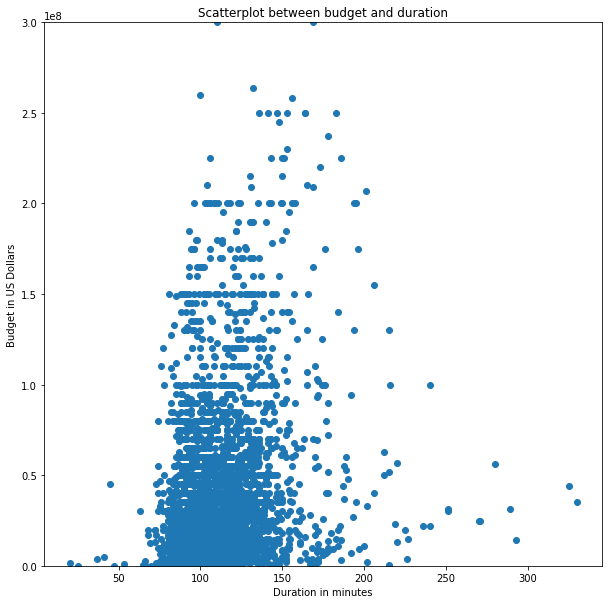

In [21]:
fig = plt.figure(1, figsize=(10,10))

y_budget = df_movies[['budget']]
x_duration = df_movies[['duration']]

axScatter = plt.subplot(111)
axScatter.scatter(x_duration, y_budget)
plt.ylim(0, 300000000)
axScatter.set_title('Scatterplot between budget and duration')
axScatter.set_xlabel('Duration in minutes')
axScatter.set_ylabel('Budget in US Dollars')

We can add another dataset to see the gender of every actor.
Both datasets come from the same source: The Movie Database. 
So we'll join them on the title.

In [22]:
df_credits = pd.read_csv('tmdb_5000_credits.csv')
df_credits = df_credits.rename(columns={'title': 'movie_title'})
df_credits

,movie_id,movie_title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de..."
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de..."
4801,126186,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de..."


In [23]:
movie_with_cast = pd.merge(df_movies, df_credits, how="inner", on="movie_title")
movie_with_cast

,movie_imdb_link,movie_title,imdb_score,title_year,director_name,director_facebook_likes,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,...,genre_Horror,genre_Music,genre_Film-Noir,genre_War,genre_Western,budget,gross,movie_id,cast,crew
0,tt0499549,Avatar,7.9,2009-01-01,James Cameron,0,CCH Pounder,1000,Joel David Moore,936,...,False,False,False,False,False,237000000.0,760505847.0,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,tt0449088,Pirates of the Caribbean: At World's End,7.1,2007-01-01,Gore Verbinski,563,Johnny Depp,40000,Orlando Bloom,5000,...,False,False,False,False,False,300000000.0,309404152.0,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,tt2379713,Spectre,6.8,2015-01-01,Sam Mendes,0,Christoph Waltz,11000,Rory Kinnear,393,...,False,False,False,False,False,245000000.0,200074175.0,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,tt1345836,The Dark Knight Rises,8.5,2012-01-01,Christopher Nolan,22000,Tom Hardy,27000,Christian Bale,23000,...,False,False,False,False,False,250000000.0,448130642.0,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,tt0401729,John Carter,6.6,2012-01-01,Andrew Stanton,475,Daryl Sabara,640,Samantha Morton,632,...,False,False,False,False,False,263700000.0,73058679.0,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,tt0388838,Clean,6.9,2004-01-01,Olivier Assayas,107,Maggie Cheung,576,Béatrice Dalle,133,...,False,True,False,False,False,4500.0,136007.0,39851,"[{""cast_id"": 1, ""character"": ""Emily Wang"", ""cr...","[{""credit_id"": ""52fe47369251416c9106db9b"", ""de..."
4246,tt0255094,The Circle,7.5,2000-01-01,Jafar Panahi,397,Fereshteh Sadre Orafaiy,5,Nargess Mamizadeh,0,...,False,False,False,False,False,10000.0,673780.0,13898,"[{""cast_id"": 3, ""character"": ""Nargess"", ""credi...","[{""credit_id"": ""52fe45b09251416c7505f189"", ""de..."
4247,tt0390384,Primer,7.0,2004-01-01,Shane Carruth,291,Shane Carruth,291,David Sullivan,45,...,False,False,False,False,False,7000.0,424760.0,14337,"[{""cast_id"": 1, ""character"": ""Aaron"", ""credit_...","[{""credit_id"": ""52fe45e79251416c75066791"", ""de..."
4248,tt0104815,El Mariachi,6.9,1992-01-01,Robert Rodriguez,0,Carlos Gallardo,121,Peter Marquardt,20,...,False,False,False,False,False,7000.0,2040920.0,9367,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."


Cast is a nested field, this function will return the gender for the given cast and name.

In [24]:

def actor_to_gender(cast, name):
    cast = json.loads(cast)
    for actor in cast:
        if name == actor['name']:
            return actor['gender']
    return 0
 
movie_with_cast['actor_1_gender'] = movie_with_cast.apply(lambda movie: actor_to_gender(movie.cast, movie.actor_1_name), axis=1)
movie_with_cast['actor_2_gender'] = movie_with_cast.apply(lambda movie: actor_to_gender(movie.cast, movie.actor_2_name), axis=1)
movie_with_cast['actor_3_gender'] = movie_with_cast.apply(lambda movie: actor_to_gender(movie.cast, movie.actor_3_name), axis=1)


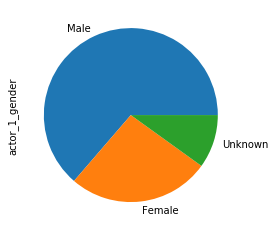

In [25]:
movie_with_cast.actor_1_gender.value_counts().plot(kind='pie', labels=['Male', 'Female', 'Unknown'])
plt.show();

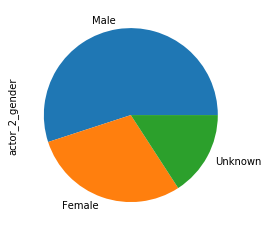

In [26]:
movie_with_cast.actor_2_gender.value_counts().plot(kind='pie', labels=['Male', 'Female', 'Unknown'])
plt.show();

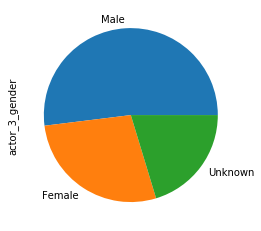

In [27]:
movie_with_cast.actor_3_gender.value_counts().plot(kind='pie', labels=['Male', 'Female', 'Unknown'])
plt.show();

The gender ratio is for the majority the same among the first three featured actors.

In [28]:
#from pandas.plotting import scatter_matrix
#plt_scatter = scatter_matrix(df_movies[['num_critic_for_reviews', 'director_facebook_likes', 'actor_1_facebook_likes', 'gross', 'cast_total_facebook_likes', 'num_user_for_reviews', 'budget', 'imdb_score', 'movie_facebook_likes']], alpha=0.2, figsize=(9,9), diagonal='kde').view()
#plt.show()

## What happens if we cluster this dataset, leaving out the genre variable?

The goal is to see if groups that were formed as a result of clustering, make any sense when comparing it to genre. Lets make a subset of the dataframe picking up all the variables except the boolean categorical values.

In [29]:
df_nogenre = df_movies[['movie_imdb_link', 'movie_title', 'genres', 'imdb_score', 'title_year',
       'director_name', 'director_facebook_likes', 'actor_1_name',
       'actor_1_facebook_likes', 'actor_2_name', 'actor_2_facebook_likes',
       'actor_3_name', 'actor_3_facebook_likes', 'cast_total_facebook_likes',
       'movie_facebook_likes', 'country', 'language',
       'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users',
       'plot_keywords', 'color', 'content_rating', 'duration', 'aspect_ratio',
       'facenumber_in_poster', 'budget', 'gross']]
df_nogenre.shape

(4411, 28)

### Data pre-processing

See if clustering with k-Means using a few combinations of numerical values will create easy-to-understand groups. There are alot of categorical variables in this set, these ones will have to drop because k-Means can only use numerical variables. There is an algorithm that is similar to k-Means that is based on categorical variables. This algorithm is called k-Modes. The most important categorical variables which should indicate genre's/similar groups are actors and directors. Let's see if we can use k-Modes.

In [30]:
print('Unique actors on 1: ', df_nogenre['actor_1_name'].unique().size)
print('Unique actors on 2: ', df_nogenre['actor_2_name'].unique().size)
print('Unique actors on 3: ', df_nogenre['actor_3_name'].unique().size)
print('Unique directors: ', df_nogenre['director_name'].unique().size)

Unique actors on 1:  1804
Unique actors on 2:  2672
Unique actors on 3:  3142
Unique directors:  2078


The important categorical variables have many unique values in comparison with the amount of records. Therefore we will not use the k-Modes algorithm. Since we have facebook likes for each director and actor, we can use these numerical values for the k-Means algorithm. Let's see a sample of those likes.

In [31]:
df_nogenre.head(5)

,movie_imdb_link,movie_title,genres,imdb_score,title_year,director_name,director_facebook_likes,actor_1_name,actor_1_facebook_likes,actor_2_name,...,num_user_for_reviews,num_voted_users,plot_keywords,color,content_rating,duration,aspect_ratio,facenumber_in_poster,budget,gross
0,tt0499549,Avatar,Action|Adventure|Fantasy|Sci-Fi,7.9,2009-01-01,James Cameron,0,CCH Pounder,1000,Joel David Moore,...,3054,886204,avatar future marine native paraplegic,Color,PG-13,178,1.78,0,237000000.0,760505847.0
1,tt0449088,Pirates of the Caribbean: At World's End,Action|Adventure|Fantasy,7.1,2007-01-01,Gore Verbinski,563,Johnny Depp,40000,Orlando Bloom,...,1238,471220,goddess marriage ceremony marriage proposal pi...,Color,PG-13,169,2.35,0,300000000.0,309404152.0
2,tt2379713,Spectre,Action|Adventure|Thriller,6.8,2015-01-01,Sam Mendes,0,Christoph Waltz,11000,Rory Kinnear,...,994,275868,bomb espionage sequel spy terrorist,Color,PG-13,148,2.35,1,245000000.0,200074175.0
3,tt1345836,The Dark Knight Rises,Action|Thriller,8.5,2012-01-01,Christopher Nolan,22000,Tom Hardy,27000,Christian Bale,...,2701,1144337,deception imprisonment lawlessness police offi...,Color,PG-13,164,2.35,0,250000000.0,448130642.0
5,tt0401729,John Carter,Action|Adventure|Sci-Fi,6.6,2012-01-01,Andrew Stanton,475,Daryl Sabara,640,Samantha Morton,...,738,212204,alien american civil war male nipple mars prin...,Color,PG-13,132,2.35,1,263700000.0,73058679.0


Hmm, that is strange. A highly appraised director such as James Cameron has zero facebook likes. Visiting his facebook page, this is not the case. Avatar is not the only one that James Cameron has directed. 

In [32]:
df_nogenre.loc[df_nogenre['director_name'] == 'James Cameron']

,movie_imdb_link,movie_title,genres,imdb_score,title_year,director_name,director_facebook_likes,actor_1_name,actor_1_facebook_likes,actor_2_name,...,num_user_for_reviews,num_voted_users,plot_keywords,color,content_rating,duration,aspect_ratio,facenumber_in_poster,budget,gross
0,tt0499549,Avatar,Action|Adventure|Fantasy|Sci-Fi,7.9,2009-01-01,James Cameron,0,CCH Pounder,1000,Joel David Moore,...,3054,886204,avatar future marine native paraplegic,Color,PG-13,178,1.78,0,237000000.0,760505847.0
26,tt0120338,Titanic,Drama|Romance,7.7,1997-01-01,James Cameron,0,Leonardo DiCaprio,29000,Kate Winslet,...,2528,793059,artist love ship titanic wet,Color,PG-13,194,2.35,0,200000000.0,658672302.0
288,tt0103064,Terminator 2: Judgment Day,Action|Sci-Fi,8.5,1991-01-01,James Cameron,0,Joe Morton,780,Jenette Goldstein,...,983,744891,future liquid metal multiple cameos sexy woman...,Color,R,153,2.35,0,102000000.0,204843350.0
291,tt0111503,True Lies,Action|Comedy|Thriller,7.2,1994-01-01,James Cameron,0,Jamie Lee Curtis,2000,Tia Carrere,...,351,190439,espionage secret agent secret mission spy spy ...,Color,R,141,2.35,0,115000000.0,146282411.0
606,tt0096754,The Abyss,Adventure|Drama|Sci-Fi|Thriller,7.6,1989-01-01,James Cameron,0,Michael Biehn,2000,Todd Graff,...,380,131217,alien estranged couple ocean submarine underwater,Color,PG-13,171,2.35,0,69500000.0,54222000.0
2486,tt0090605,Aliens,Action|Adventure|Sci-Fi,8.4,1986-01-01,James Cameron,0,Michael Biehn,2000,Carrie Henn,...,1076,488537,alien human versus alien monster rescue missio...,Color,R,154,1.85,1,18500000.0,85200000.0
3575,tt0088247,The Terminator,Action|Sci-Fi,8.1,1984-01-01,James Cameron,0,Michael Biehn,2000,Brian Thompson,...,692,600266,cyborg future war robot shootout in a police s...,Color,R,107,1.85,1,6500000.0,38400000.0


All of his great works contain zero facebook likes as a director. Something went probably wrong during the retrieval of this dataset. 

A first option would be to scrape all director facebook likes properly where director_facebook_likes == 0. But this means that you would get a new timestamp of data retrieval, resulting in doing harm to the integrity of the data. Let's not do that.

Another option would be to scrape ALL of the directors facebook likes, but that is out of scope for this research.

In [33]:
df_nogenre.loc[df_nogenre['director_facebook_likes'] == 0].shape[0]

745

The amount of rows with directors having zero facebook likes is 745. Dropping these would also mean dropping strong movies such as Titanic. Let's leave this variable for now.

In [34]:
print(df_nogenre.loc[df_nogenre['actor_1_facebook_likes'] == 0].shape[0])
print(df_nogenre.loc[df_nogenre['actor_2_facebook_likes'] == 0].shape[0])
print(df_nogenre.loc[df_nogenre['actor_3_facebook_likes'] == 0].shape[0])

10
26
53


The amount of rows with actors having zero facebook likes totals around 80. We can drop these rows and keep the rest for our k-Means model.

In [35]:
print('Rows before:', df_nogenre.shape[0])
df_nogenre.drop(df_nogenre.loc[df_nogenre['actor_1_facebook_likes'] == 0].index, inplace=True)
df_nogenre.drop(df_nogenre.loc[df_nogenre['actor_2_facebook_likes'] == 0].index, inplace=True)
df_nogenre.drop(df_nogenre.loc[df_nogenre['actor_3_facebook_likes'] == 0].index, inplace=True)
print('Rows left:', df_nogenre.shape[0])

Rows before: 4411
Rows left: 4358


C:\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The column cast_total_facebook_likes looks like a summation of all 3 actor's facebook likes. Let's test this.

In [36]:
df_nogenre[['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes']].sum(1)
boolean_arr = np.where(df_nogenre[['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes']].sum(1) == df_nogenre['cast_total_facebook_likes']
                     , 'True', 'False')
truefalse, amount = np.unique(boolean_arr, return_counts=True)
np.asarray((truefalse, amount))

array([['False', 'True'],
       ['4319', '39']], dtype='<U21')

Apparently this is false for most of the rows. This means this column is not a result of 2 columns combined, which would interfere with creating the kMeans clusters. Let's keep this column.

Since we noted that the data might be invalid, let's see how many rows we have for each of the remaining columns being on 0.

In [37]:
print(df_nogenre.loc[df_nogenre['movie_facebook_likes'] == 0].shape[0])
print(df_nogenre.loc[df_nogenre['num_critic_for_reviews'] == 0].shape[0])
print(df_nogenre.loc[df_nogenre['num_user_for_reviews'] == 0].shape[0])
print(df_nogenre.loc[df_nogenre['num_voted_users'] == 0].shape[0])
print(df_nogenre.loc[df_nogenre['facenumber_in_poster'] == 0].shape[0])
print(df_nogenre.loc[df_nogenre['budget'] == 0].shape[0])
print(df_nogenre.loc[df_nogenre['gross'] == 0].shape[0])
print(df_nogenre.loc[df_nogenre['cast_total_facebook_likes'] == 0].shape[0])

1994
0
0
0
1849
0
0
0


The amount of rows with movies having zero facebook likes is 1994. This makes sense because the dataset contains data from movies made in 1934 till 2016. Facebook was founded in 2004. Let's not use this column.

Facenumber in poster having zero makes sense, because it can contain posters not having a face on it, for example alot of thriller movies.

Since we are going with k-Means algorithm, let's drop all categorical variables as well, except for the identifiers (movie_imdb_link, movie_title, genres). We can also skip the mentioned director_facebook_likes and movie_facebook_likes column due to it's data being invalid.

In [38]:
df_nocat = df_nogenre[['movie_imdb_link', 'movie_title', 'genres', 'imdb_score', 'title_year', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
       'actor_3_facebook_likes', 'cast_total_facebook_likes', 'num_critic_for_reviews', 'num_user_for_reviews', 
       'num_voted_users', 'duration', 'aspect_ratio', 'facenumber_in_poster', 'budget', 'gross']]
df_nocat.head(5)

,movie_imdb_link,movie_title,genres,imdb_score,title_year,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,cast_total_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,duration,aspect_ratio,facenumber_in_poster,budget,gross
0,tt0499549,Avatar,Action|Adventure|Fantasy|Sci-Fi,7.9,2009-01-01,1000,936,855,4834,723,3054,886204,178,1.78,0,237000000.0,760505847.0
1,tt0449088,Pirates of the Caribbean: At World's End,Action|Adventure|Fantasy,7.1,2007-01-01,40000,5000,1000,48350,302,1238,471220,169,2.35,0,300000000.0,309404152.0
2,tt2379713,Spectre,Action|Adventure|Thriller,6.8,2015-01-01,11000,393,161,11700,602,994,275868,148,2.35,1,245000000.0,200074175.0
3,tt1345836,The Dark Knight Rises,Action|Thriller,8.5,2012-01-01,27000,23000,23000,106759,813,2701,1144337,164,2.35,0,250000000.0,448130642.0
5,tt0401729,John Carter,Action|Adventure|Sci-Fi,6.6,2012-01-01,640,632,530,1873,462,738,212204,132,2.35,1,263700000.0,73058679.0


Because k-Means works with using the mean of a cluster, a date variable would make no sense. We can transform this variable to a numerical value. Since this dataset only contain year numbers, we only need to extract the year.

In [39]:
df_nocat['title_year'] = pd.DatetimeIndex(df_nocat['title_year']).year
df_nocat['title_year']

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0       2009
1       2007
2       2015
3       2012
5       2012
        ... 
5026    2004
5029    1997
5033    2004
5035    1992
5042    2004
Name: title_year, Length: 4358, dtype: int64

To optimize the results of k-Means, let's use the Z-Score form of standardization (as opposed to min-max or decimal normalization) for all of the variables. We can only standardize if there are no NaN values, so we should drop them. The data is now ready to be clustered using the k-Means algorithm.

In [40]:
df_nocat = df_nocat.dropna()
df_nocat[['imdb_score']] = (df_nocat[['imdb_score']]-df_nocat[['imdb_score']].mean())/df_nocat[['imdb_score']].std()
df_nocat[['actor_1_facebook_likes']] = (df_nocat[['actor_1_facebook_likes']]-df_nocat[['actor_1_facebook_likes']].mean())/df_nocat[['actor_1_facebook_likes']].std()
df_nocat[['actor_2_facebook_likes']] = (df_nocat[['actor_2_facebook_likes']]-df_nocat[['actor_2_facebook_likes']].mean())/df_nocat[['actor_2_facebook_likes']].std()
df_nocat[['actor_3_facebook_likes']] = (df_nocat[['actor_3_facebook_likes']]-df_nocat[['actor_3_facebook_likes']].mean())/df_nocat[['actor_3_facebook_likes']].std()
df_nocat[['cast_total_facebook_likes']] = (df_nocat[['cast_total_facebook_likes']]-df_nocat[['cast_total_facebook_likes']].mean())/df_nocat[['cast_total_facebook_likes']].std()
df_nocat[['num_critic_for_reviews']] = (df_nocat[['num_critic_for_reviews']]-df_nocat[['num_critic_for_reviews']].mean())/df_nocat[['num_critic_for_reviews']].std()
df_nocat[['num_user_for_reviews']] = (df_nocat[['num_user_for_reviews']]-df_nocat[['num_user_for_reviews']].mean())/df_nocat[['num_user_for_reviews']].std()
df_nocat[['num_voted_users']] = (df_nocat[['num_voted_users']]-df_nocat[['num_voted_users']].mean())/df_nocat[['num_voted_users']].std()
df_nocat[['duration']] = (df_nocat[['duration']]-df_nocat[['duration']].mean())/df_nocat[['duration']].std()
df_nocat[['aspect_ratio']] = (df_nocat[['aspect_ratio']]-df_nocat[['aspect_ratio']].mean())/df_nocat[['aspect_ratio']].std()
df_nocat[['facenumber_in_poster']] = (df_nocat[['facenumber_in_poster']]-df_nocat[['facenumber_in_poster']].mean())/df_nocat[['facenumber_in_poster']].std()
df_nocat[['budget']] = (df_nocat[['budget']]-df_nocat[['budget']].mean())/df_nocat[['budget']].std()
df_nocat[['gross']] = (df_nocat[['gross']]-df_nocat[['gross']].mean())/df_nocat[['gross']].std()
df_nocat[['title_year']] = (df_nocat[['title_year']]-df_nocat[['title_year']].mean())/df_nocat[['title_year']].std()
df_nocat

,movie_imdb_link,movie_title,genres,imdb_score,title_year,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,cast_total_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,duration,aspect_ratio,facenumber_in_poster,budget,gross
0,tt0499549,Avatar,Action|Adventure|Fantasy|Sci-Fi,1.360643,0.616665,-0.428416,-0.233330,0.053501,-0.343864,4.563894,6.702252,5.137400,2.975259,-0.927157,-0.673102,0.851284,10.232566
1,tt0449088,Pirates of the Caribbean: At World's End,Action|Adventure|Fantasy,0.603711,0.414251,2.069155,0.666565,0.131843,1.931965,1.123491,2.232898,2.409388,2.579872,0.677745,-0.673102,1.130882,3.719467
2,tt2379713,Spectre,Action|Adventure|Thriller,0.319862,1.223908,0.211987,-0.353567,-0.321460,0.015219,3.575085,1.632390,1.125188,1.657301,0.677745,-0.190446,0.886788,2.140938
3,tt1345836,The Dark Knight Rises,Action|Thriller,1.928342,0.920287,1.236632,4.652320,12.018209,4.986679,5.299372,5.833484,6.834308,2.360212,0.677745,-0.673102,0.908979,5.722429
5,tt0401729,John Carter,Action|Adventure|Sci-Fi,0.130629,0.920287,-0.451471,-0.300645,-0.122093,-0.498720,2.431007,1.002349,0.706675,0.954389,0.677745,-0.190446,0.969780,0.307063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5026,tt0388838,Clean,Drama|Music|Romance,0.414478,0.110630,-0.455569,-0.411139,-0.384133,-0.556092,-0.682517,-0.717958,-0.662511,-0.012114,0.677745,-0.190446,-0.200516,-0.745810
5029,tt0123948,The Cure,Crime|Horror|Mystery|Thriller,0.887561,-0.597821,-0.486757,-0.437710,-0.405204,-0.590661,-0.707033,-0.690886,-0.646773,0.031818,-0.730064,-0.673102,-0.196098,-0.746408
5033,tt0390384,Primer,Drama|Sci-Fi|Thriller,0.509095,0.110630,-0.473821,-0.430625,-0.404124,-0.577430,-0.175854,0.099127,-0.210794,-1.461868,-0.730064,-0.673102,-0.200505,-0.741641
5035,tt0104815,El Mariachi,Action|Crime|Drama|Romance|Thriller,0.414478,-1.103856,-0.484708,-0.436160,-0.405204,-0.588988,-0.886816,-0.493998,-0.346109,-1.286141,-2.081560,-0.673102,-0.200505,-0.718306


### Model building

We need to decide on a heuristic to evaluate if the clustered groups have any connection with the genre of a movie. The total amount of genres in this dataset is 28. We can say that if in every cluster there is a certain genre for >60% of that cluster, then it's safe to say that the clustering made sense (success). If it fails, then the clustering failed to make groups split by genre. In essence, we are actually testing the classification of the clustering by using the genre variable.

We need to define a function that will let us choose the hyperparameters for the model building. We are only going to toy with the amount of clusters, the list of genres and which variables will be picked up for clustering. The function will print a tuple containing the cluster, percentage of the genre and the genre itself if it passes the heuristic.

To start lets create a function that prints out a commonly found genre per cluster. We set the n_cluster to 28 (amount of genre), heuristic percentage to 60% and pick up all numeric variables.

In [41]:
n_cluster = 28
heuristic_perc = 60
chosen_genres = list(set(itertools.chain.from_iterable(df_nocat.genres.str.split('|'))))
chosen_var = df_nocat.iloc[:,3:df_nocat.shape[1]].columns

def sum_per_cluster(df, list_var, list_genres, n_clsters, heuristic_percentage):
    print('Cluster\tPercentage\tGenre')
    allMeans = KMeans(n_clusters=n_clsters, random_state=0).fit(df.loc[:,list_var])
    df['Clusters'] = allMeans.predict(df.loc[:,list_var])
    for cluster in range(0,n_cluster):
        for genre in list_genres:
            percentage = (df.loc[df['Clusters'] == cluster].genres.str.contains(genre).sum() / df.loc[df['Clusters'] == cluster].shape[0]) * 100
            if percentage >= heuristic_percentage:
                print(cluster, '\t', np.around(percentage, decimals=2), '\t\t', genre)
                
sum_per_cluster(df_nocat, chosen_var, chosen_genres, n_cluster, heuristic_perc)

Cluster	Percentage	Genre
1 	 61.08 		 Drama
4 	 71.94 		 Comedy
5 	 100.0 		 Comedy
6 	 100.0 		 Comedy
6 	 100.0 		 Drama
6 	 100.0 		 Sci-Fi
6 	 100.0 		 Horror
7 	 100.0 		 Documentary
8 	 66.23 		 Comedy
9 	 72.85 		 Comedy
10 	 100.0 		 Horror
11 	 61.73 		 Drama
14 	 62.5 		 Fantasy
14 	 87.5 		 Adventure
14 	 75.0 		 Action
14 	 75.0 		 Sci-Fi
16 	 92.86 		 Drama
18 	 90.32 		 Drama
20 	 65.53 		 Drama
21 	 100.0 		 Drama
22 	 66.67 		 Adventure
22 	 66.67 		 Animation
23 	 70.0 		 Adventure
25 	 87.2 		 Drama
26 	 81.82 		 Adventure


There are a few things to note about these results. There are a few clusters that contain 100% of a certain genre. This might seem ideal, but it could also be due to the small size of a cluster. We also see alot of the genre Drama. 

The result could be abit messy because:
- There is no minimum on the size of a cluster when testing the heuristic
- We set the amount of clusters to 28, because of the amount of genres. But the genres may not be even distributed and a movie may contain multiple genres.

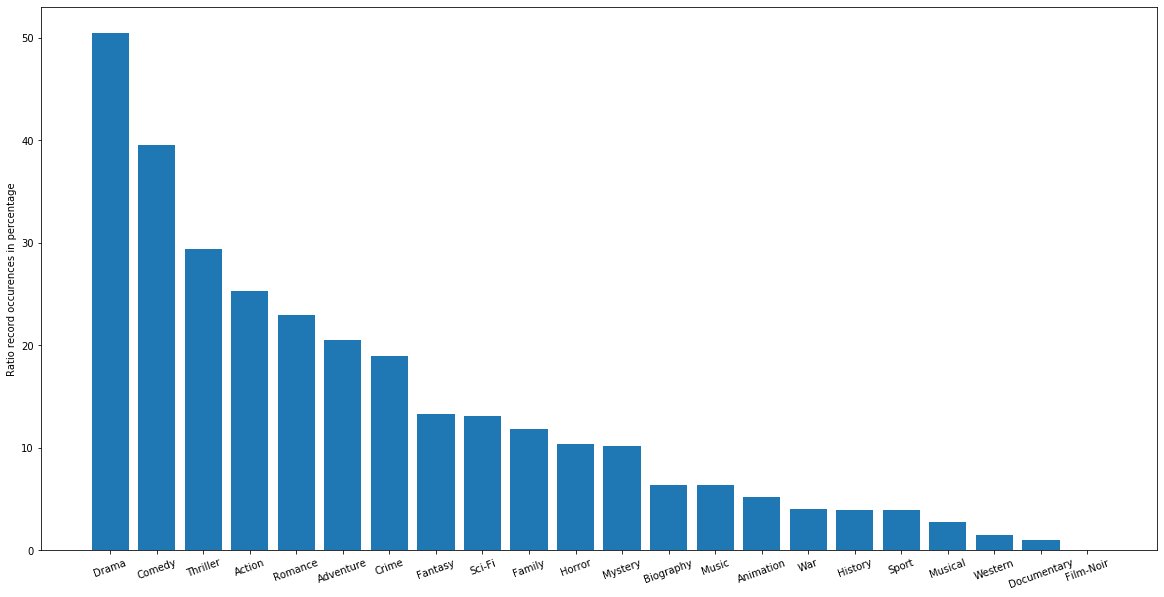

In [42]:
list_genres = list(set(itertools.chain.from_iterable(df_nocat.genres.str.split('|'))))
genre_percentage = list()

for genre in list_genres:
    percentage = df_nocat.loc[df_nocat['genres'].str.contains(genre)].shape[0] / df_nocat.shape[0] * 100
    genre_percentage.append((genre, np.around(percentage, decimals=2)))
    
genre_percentage.sort(key=lambda x: x[1], reverse=True)

pl_genre = [i[0] for i in genre_percentage]
pl_percentage = [i[1] for i in genre_percentage]
x_pos = np.arange(len(pl_genre)) 

plt.figure(figsize=(20,10))
plt.bar(x_pos, pl_percentage,align='center')
plt.xticks(x_pos, pl_genre, rotation=20) 
plt.ylabel('Ratio record occurences in percentage')
plt.show()

As you can see, Drama appears to be in about 50% of the dataset. The least appearing genres would be Western, Documentary and Film-Noir.

In [43]:
print(df_nocat.loc[df_nocat['genres'].str.contains('Western')].shape[0], 'movies with Western')
print(df_nocat.loc[df_nocat['genres'].str.contains('Documentary')].shape[0], 'movies with Documentary')
print(df_nocat.loc[df_nocat['genres'].str.contains('Film-Noir')].shape[0], 'movies with Film-Noir')

56 movies with Western
35 movies with Documentary
1 movies with Film-Noir


Film-Noir only appears on 1 row. Western and Documentary stand on their own.

We can try again with less clusters, combining some genre's. When testing these clusters, all of the genres within the defined genre should appear in that row. Let's cap the total combined genre's at 14. These genre's will be either combined with AND (?=.*) or OR (|) in regex.

In [44]:
new_genre_list = ['(?=.*Drama)(?=.*Romance)', '(?=.*Comedy)(?=.*Romance)', '(?=.*Action)(?=.*Adventure)', 'Sport', 'Crime',
                  '(?=.*Drama)(?=.*Thriller)', 'Horror|Mystery', '(?=.*Comedy)(?=.*Family)', '(?=.*Action)(?=.*Sci-Fi)'
                  , 'War|History|Western', 'Animation', 'Music|Musical', 'Documentary|Biography', '(?=.*Action)(?=.*Fantasy)']

We tried to combine the higher occuring genres alot, so that it evens out. Let's see what the current distribution between the combined genre's are.

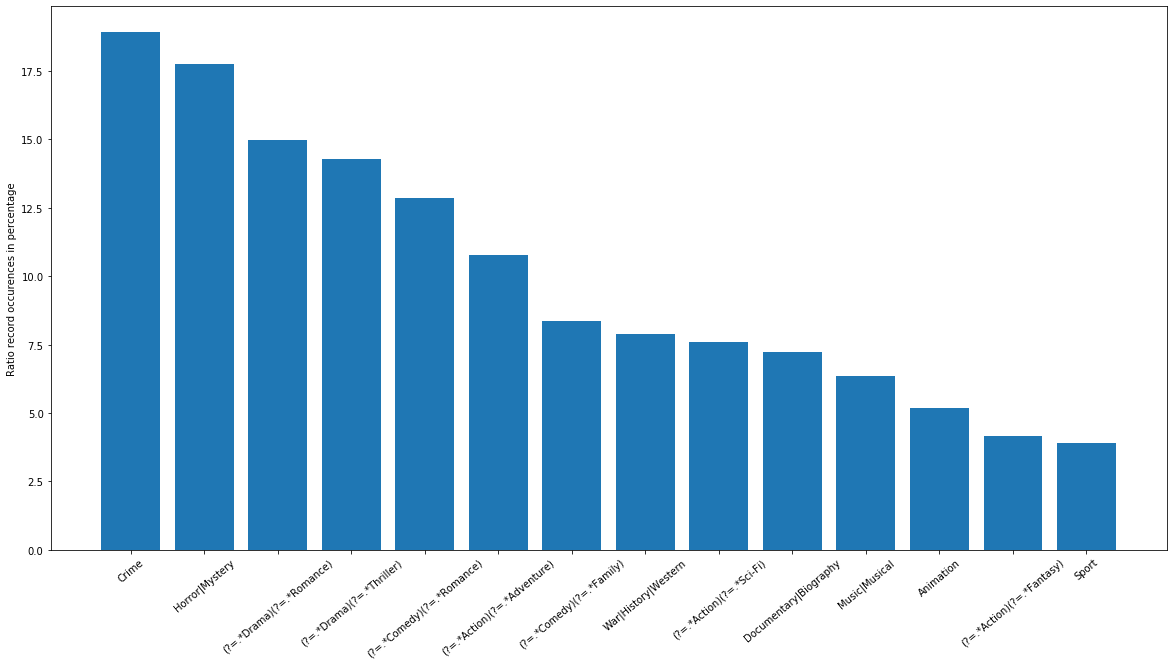

In [45]:
genre_percentage = list()

for genre in new_genre_list:
    percentage = df_nocat.loc[df_nocat['genres'].str.contains(genre, regex=True)].shape[0] / df_nocat.shape[0] * 100
    genre_percentage.append((genre, np.around(percentage, decimals=2)))
    
genre_percentage.sort(key=lambda x: x[1], reverse=True)

pl_genre = [i[0] for i in genre_percentage]
pl_percentage = [i[1] for i in genre_percentage]
x_pos = np.arange(len(pl_genre)) 

plt.figure(figsize=(20,10))
plt.bar(x_pos, pl_percentage,align='center')
plt.xticks(x_pos, pl_genre, rotation=40) 
plt.ylabel('Ratio record occurences in percentage')
plt.show()

The new genre balances out somewhat better than before.

We need to add the new heuristic (size of cluster) and test cases (combined genre) to the function. For the size of a cluster, let's pick a minimum of 20. We also lower the percentage range from 60 to 25 to be able to print results.

In [46]:
#Drop last Cluster
df_nocat = df_nocat.iloc[:, :-1]

n_cluster = 14
heuristic_perc = 25
chosen_genres = new_genre_list
chosen_var = df_nocat.iloc[:,3:df_nocat.shape[1]].columns

def sum_per_cluster(df, list_var, list_genres, n_clsters, heuristic_percentage):
    print('Cluster\tPercentage\tGenre')
    allMeans = KMeans(n_clusters=n_clsters, random_state=0).fit(df.loc[:,list_var])
    df['Clusters'] = allMeans.predict(df.loc[:,list_var])
    for cluster in range(0,n_cluster):
        if df.loc[df['Clusters'] == cluster].shape[0] < 20:
            continue
        for genre in list_genres:
            percentage = (df.loc[df['Clusters'] == cluster].genres.str.contains(genre, regex=True).sum() / df.loc[df['Clusters'] == cluster].shape[0]) * 100
            if percentage >= heuristic_percentage:
                print(cluster, '\t', np.around(percentage, decimals=2), '\t\t', genre)
                
sum_per_cluster(df_nocat, chosen_var, chosen_genres, n_cluster, heuristic_perc)

Cluster	Percentage	Genre
2 	 56.36 		 (?=.*Action)(?=.*Adventure)
2 	 32.73 		 (?=.*Action)(?=.*Sci-Fi)
2 	 30.91 		 (?=.*Action)(?=.*Fantasy)
8 	 25.34 		 Horror|Mystery
9 	 26.36 		 Crime


Hmm looks like the results are even worse when combining genres, because the percentages are alot lower. How about if we pick different variables? Let's keep all social media stuff and remove properties from the movie itself (and vica versa)

In [47]:
chosen_var = ['imdb_score', 'actor_1_facebook_likes',
       'actor_2_facebook_likes', 'actor_3_facebook_likes',
       'cast_total_facebook_likes', 'num_critic_for_reviews',
       'num_user_for_reviews', 'num_voted_users']

sum_per_cluster(df_nocat, chosen_var, chosen_genres, n_cluster, heuristic_perc)

Cluster	Percentage	Genre
4 	 34.74 		 (?=.*Action)(?=.*Adventure)
4 	 27.37 		 (?=.*Action)(?=.*Sci-Fi)
8 	 28.64 		 Crime
11 	 37.04 		 (?=.*Action)(?=.*Adventure)
11 	 25.93 		 (?=.*Action)(?=.*Sci-Fi)
11 	 27.78 		 (?=.*Action)(?=.*Fantasy)
13 	 25.68 		 Horror|Mystery


In [48]:
chosen_var = ['title_year', 'duration', 'aspect_ratio',
       'facenumber_in_poster', 'budget', 'gross']

sum_per_cluster(df_nocat, chosen_var, chosen_genres, n_cluster, heuristic_perc)

Cluster	Percentage	Genre
1 	 28.66 		 (?=.*Action)(?=.*Adventure)
3 	 25.7 		 (?=.*Drama)(?=.*Thriller)
5 	 29.24 		 (?=.*Comedy)(?=.*Romance)
7 	 46.88 		 War|History|Western
7 	 31.25 		 Documentary|Biography
8 	 26.86 		 Horror|Mystery
9 	 33.33 		 Music|Musical
13 	 46.51 		 (?=.*Action)(?=.*Adventure)
13 	 33.72 		 (?=.*Action)(?=.*Sci-Fi)


### Conclusion

In the latter model we see somewhat more distinct genres. However the percentages are still not good enough to say that kMeans can cluster this set into different groups of genres. To give it a better picture, we can visualize this by plotting the largest 3 clusters and their genre distribution.

In [49]:
df_nocat.Clusters.value_counts()

8     916
12    749
3     502
0     364
5     342
1     314
6     256
13     86
7      64
9      51
11      3
10      3
4       1
2       1
Name: Clusters, dtype: int64

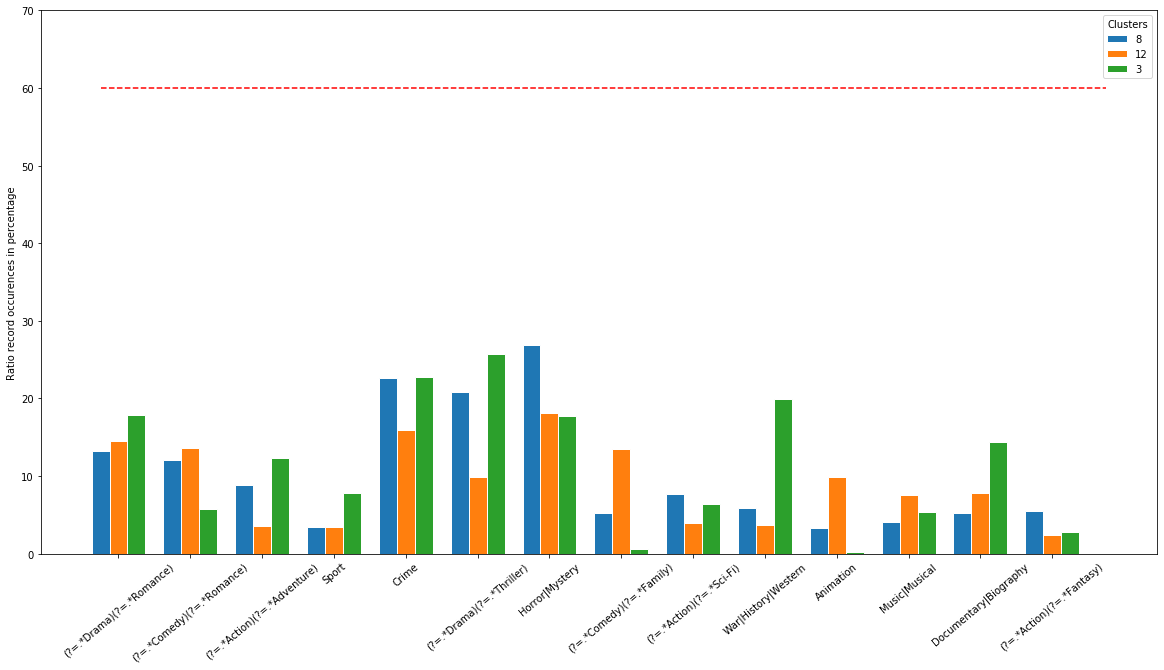

In [50]:
df8 = df_nocat.loc[df_nocat['Clusters'] == 8]
df12 = df_nocat.loc[df_nocat['Clusters'] == 12]
df3 = df_nocat.loc[df_nocat['Clusters'] == 3]

genre_percentage8 = list()
genre_percentage12 = list()
genre_percentage3 = list()

for genre in new_genre_list:
    percentage8 = df8.loc[df8['genres'].str.contains(genre, regex=True)].shape[0] / df8.shape[0] * 100
    percentage12 = df12.loc[df12['genres'].str.contains(genre, regex=True)].shape[0] / df12.shape[0] * 100
    percentage3 = df3.loc[df3['genres'].str.contains(genre, regex=True)].shape[0] / df3.shape[0] * 100
    genre_percentage8.append((genre, np.around(percentage8, decimals=2)))
    genre_percentage12.append((genre, np.around(percentage12, decimals=2)))
    genre_percentage3.append((genre, np.around(percentage3, decimals=2)))

barwidth = 0.25    

pl_genre8 = [i[0] for i in genre_percentage8]
pl_percentage8 = [i[1] for i in genre_percentage8]
pl_percentage12 = [i[1] for i in genre_percentage12]
pl_percentage3 = [i[1] for i in genre_percentage3]
x_pos8 = np.arange(len(pl_genre))
x_pos12 = [x + barwidth for x in x_pos8]
x_pos3 = [x + barwidth for x in x_pos12]

plt.figure(figsize=(20,10))
plt.bar(x_pos8, pl_percentage8, edgecolor='white', width=barwidth)
plt.bar(x_pos12, pl_percentage12,edgecolor='white', width=barwidth)
plt.bar(x_pos3, pl_percentage3, edgecolor='white', width=barwidth)
plt.xticks([r + barwidth for r in range(len(pl_genre))], pl_genre8, rotation=40) 
plt.ylabel('Ratio record occurences in percentage')
plt.ylim(0, 70)
plt.legend(['8', '12', '3'], title='Clusters')
plt.hlines(60, xmin=0, xmax=14, linestyle='dashed', colors='red')
plt.show()

There isn't really a good distinction between the large clusters themselves, except for green maybe which outshines on War|History|Western and Documentary|Biography. **But none of the distributions are close to the 60% heuristic**. Therefor it is safe to say that clustering this dataset with kMeans **cannot** result into groups of genres.